# Breast Cancer Wisconsin

O seguinte projeto tem como objetivo reduzir a dimensionalidade dos dados usados para prever se um câncer é maligno ou benigno, para isso faremos uso do Kbest e também de algumas análises exploratórias dos dados. Após isso vamos criar um modelo de predição para os nossos dados.

## Importando e Visualizando Dados

In [37]:
# importando bibliotecas que serão usadas
import pandas as pd
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.manifold import TSNE
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit, KFold

from scipy.stats import randint

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from yellowbrick.classifier import ConfusionMatrix

In [2]:
df = pd.read_csv('data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
df.shape

(569, 33)

## Tratando os Dados

Aqui vamos fazer um tratamento nos dados, verificar se este está balanceando, se tem dados faltantes e algumas visualizações para uma melhor compreensão deste.

In [4]:
# verificando dados ausentes
df.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

Aqui podemos ver que a coluna `Unnamed: 32` é uma coluna completamente vazia e a partir disso vamos fazer a exclusão desta, assim tendo o nosso dataset mais limpo. Além disso, podemos excluir a coluna `id`. Pelo fato desta representar apenas quem é o paciente e não uma informação que permita a predição.

In [5]:
df = df.drop(columns=['Unnamed: 32', 'id'])
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Abaixo vamos criar vários plot, esse tem o intuito de vermos se tem variáveis que possamos excluir de nosso dataset. Assim diminuindo sua dimensionalidade, deixando o modelo mais leve e menos complexo.

Aqui vamos fazer um tratamento nas variáveis, vamos padronizar todas e plotar de 10 em 10 para ter uma melhor visualização dos gráficos. Assim já vamos ter uma noção melhor de qual variável eliminar.

In [6]:
# separando os dados
X = df.drop(columns='diagnosis')
y = df['diagnosis']

In [7]:
# padronizando os dados
standard = StandardScaler()
standard.fit(X)
df_std = standard.transform(X)

# criando um dataset com a padronização
df_std = pd.DataFrame(data=df_std, columns=X.keys())
df_std.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [14]:
# gráfico
def grafico(dado, inicio, fim):
  df_plot = pd.concat([y, dado.iloc[:,inicio:fim]], axis=1)
  df_plot = pd.melt(df_plot, id_vars='diagnosis', var_name='features', value_name='values')

  plt.figure(figsize=(10,10))
  sns.violinplot(x='features', y='values', hue='diagnosis', data=df_plot, split=True)

  plt.xticks(rotation=90)

In [ ]:
display(grafico(df_std, 0, 11))
display(grafico(df_std, 11, 21))
display(grafico(df_std, 21, 32))

Apenas com o gráfico de violino não podemos excluir as variáveis, entretanto podemos notar algumas variáveis mais importantes como por exemplo algumas colunas têm uma maior diferença entre as cristas que demonstram se o câncer é maligno ou benigno. Isso torna a variáveis mais importante para a predição. Para melhorar nossa análise vamos analisar a correlação entre as variáveis, pois variáveis com correlações altas entre sí podem ser excluídas da predição.

In [ ]:
# correlação 
matriz_corr = df_std.corr()

sns.set(style="white")

mask = np.zeros_like(matriz_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(18, 16))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(matriz_corr, mask=mask, annot=True, fmt='.1f', cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5});

Olhar para esse gráfico e ficar procurando valores que estejam correlacionados é algo bem trabalhoso, por isso vamos procurar esses valores altamente correlacionados ao código.

In [17]:
matriz_corr_1 = matriz_corr[matriz_corr > 0.99]

matriz_corr_2 = matriz_corr_1.sum()
var_corr = matriz_corr_2[matriz_corr_2 > 1]
var_corr

radius_mean        1.997855
perimeter_mean     1.997855
radius_worst       1.993708
perimeter_worst    1.993708
dtype: float64

In [18]:
df_1 = df_std.drop(columns=['perimeter_mean', 'perimeter_worst'])
df_1.head()

,radius_mean,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,...,fractal_dimension_se,radius_worst,texture_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.097064,-2.073335,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,...,0.907083,1.886690,-1.359293,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,...,-0.099444,1.805927,-0.369203,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,...,0.293559,1.511870,-0.023974,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,...,2.047511,-0.281464,0.133984,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,1.270543,...,0.499328,1.298575,-1.466770,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


## Criano Baseline

In [19]:
seed = 42
np.random.seed(seed)

baseline = DummyClassifier()
resultados = cross_validate(baseline, df_1, y, cv=10, return_train_score=False)
media = resultados['test_score'].mean()
desvio_padrao = resultados['test_score'].std()
print(f'Acc com dummy, 10 = [{(media - 2 * desvio_padrao).round(3) * 100, (media + 2 * desvio_padrao).round(3) * 100}]')

Acc com dummy, 10 = [(61.3, 64.1)]


In [21]:
df_1.shape

(569, 28)

## Criando Modelo com Parâmetros Padrões

Aqui já vamos fazer a criação do nosso modelo, para isso vamos fazer a criação do nosso modelo. Vamos usar o KBest para fazer uma redução de dimensionalidade. Vale lembrar que nosso Kbest não faz uso da padronização, por isso vamos usar os nossos dados sem a padronização.

In [22]:
df_2 = X.drop(columns=['perimeter_mean', 'perimeter_worst'])

In [23]:
df_2.shape

(569, 28)

In [26]:
seed = 42
np.random.seed(seed)

treino_x, teste_x, treino_y, teste_y = train_test_split(df_2, y, test_size=0.20, shuffle=True, stratify=y, random_state=42)

In [ ]:
def pipe(k):

  # treinando modelo com parâmetros padrões
  kbest = SelectKBest(chi2, k=k)

  seed = 42
  np.random.seed(seed)

  selec_kbest = kbest.fit(treino_x, treino_y)
  treino_kbest = selec_kbest.transform(treino_x)
  teste_kbest = selec_kbest.transform(teste_x)

  # aplicando modelo
  modelo = RandomForestClassifier(random_state=42)
  modelo.fit(treino_kbest, treino_y)
  print(f'Resultado da classificação {(modelo.score(teste_kbest,teste_y)*100).round(3)}')

for i in range(5, 16):
  print(pipe(i))

In [28]:
pipe(14)

Resultado da classificação 97.902


In [43]:
# pegando o melhor K
kbest = SelectKBest(chi2, k=14)

seed = 42
np.random.seed(seed)

selec_kbest = kbest.fit(treino_x, treino_y)
treino_kbest = selec_kbest.transform(treino_x)
teste_kbest = selec_kbest.transform(teste_x)

modelo = RandomForestClassifier(n_estimators=300, random_state=42)
modelo.fit(treino_kbest, treino_y)

RandomForestClassifier(n_estimators=300, random_state=42)

## Métricas Para Modelo Padrão

In [44]:
matriz_c = confusion_matrix(teste_y, modelo.predict(teste_kbest))
matriz_c

array([[90,  0],
       [ 3, 50]])

[Text(55.0, 0.5, 'Real'), Text(0.5, 37.0, 'Predição')]

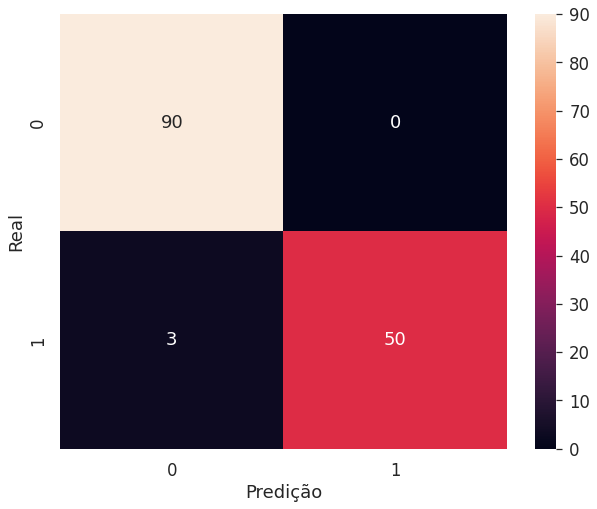

In [45]:
plt.figure(figsize=(10,8))
sns.set(font_scale=1.5)
sns.heatmap(matriz_c, annot=True, fmt='d').set(xlabel='Predição', ylabel='Real')

In [46]:
prev = modelo.predict(teste_kbest)

print(classification_report(teste_y, prev))

              precision    recall  f1-score   support

           B       0.97      1.00      0.98        90
           M       1.00      0.94      0.97        53

    accuracy                           0.98       143
   macro avg       0.98      0.97      0.98       143
weighted avg       0.98      0.98      0.98       143



Aqui conseguimos um bom recall, o que é de extrema importância, principalmente para avaliar evitar um grande número de falsos negativos que é o item que mais preocupa.

## TSNE

Aqui iremos plotar nossos dados em apenas duas dimensões, claro que isso ocasiona perdas, entretanto para uma melhor visualização se faz necessário o uso. Para isso vamos fazer o uso do TSNE. Ele mantém a distância entre os pontos. Um ponto negativo dele é o fato deste precisar de um maior poder computacional, principalmente se tiver uma maior quantidade de dados.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


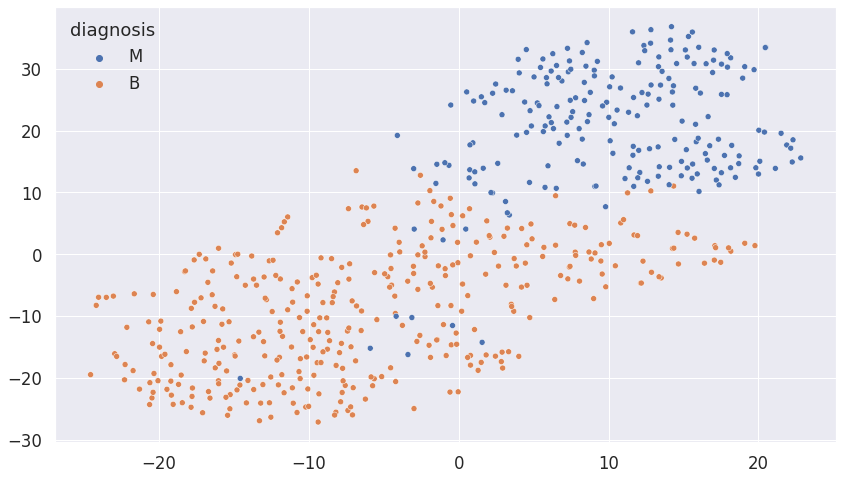

In [58]:
tsne = TSNE(n_components=2)
df_tsne = tsne.fit_transform(df_1) 

plt.figure(figsize=(14,8))
sns.scatterplot(x=df_tsne[:,0], y=df_tsne[:,1], hue=y)

Com esse gráfico pode observar que é de boa prática solicitar a pessoas que estejam na fronteira refazer os exames para que esta tenha uma melhor resposta sobre o tipo de câncer que afeta ela. Assim, evitando falhas e trazendo novas informações para os nossos dados.